In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
from dataset import load_image

In [4]:
import torch

In [5]:
from utils import variable

In [6]:
from generate_masks import get_model

In [7]:
from torchvision.transforms import ToTensor, Normalize, Compose

In [8]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [10]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from unet_models import unet11

# model_path = 'data/models/unet16_binary_20/model_0.pt'
model_path = '../TernausNet/TernausNet.pt'
# model = get_model(model_path, model_type='UNet11', problem_type='binary') # errors with this!

# this is for the carvana/building model
# model =  unet11(pretrained='carvana')
# state = torch.load(model_path)
# model.load_state_dict(state['model'])

# start from only vgg
model = unet11(pretrained=True)

# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [11]:
# import the helper functions
from test_unet_helpers import *

import rasterio
import glob
import os,sys
#from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
import numpy as np
#from scipy import misc
import fiona
# import geopandas as gpd
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

In [12]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0.tif' # desktop
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop
# gt_image_2 = '../rasters/union_impervious_raster_2_0_0.tif' # laptop
#gt_image_2 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0.tif'

# specify images for 0.5 meter analysis
gt_image_05 = '../../rasters/union_impervious_raster_0_5.tif' # desktop
# gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # laptop
#gt_image_05 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif'

# specify the shapefile
# shpfile = '../Denver_Sample_Sites/union/union_grid_index256.shp'
shpfile = '../../union/union.shp' # desktop
# shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
#     for s in shp:
#         # rows.append(shape(s['geometry']))
#         pass
        
        
    shp_bounds = shp.bounds

In [13]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [14]:
os.path.exists(gt_image_2)

True

In [15]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

generating sample 1 of 10000
generating sample 2 of 10000
generating sample 3 of 10000
generating sample 4 of 10000
generating sample 5 of 10000
generating sample 6 of 10000
generating sample 7 of 10000
generating sample 8 of 10000
generating sample 9 of 10000
generating sample 10 of 10000
generating sample 11 of 10000
generating sample 12 of 10000
generating sample 13 of 10000
generating sample 14 of 10000
generating sample 15 of 10000
generating sample 16 of 10000
generating sample 17 of 10000
generating sample 18 of 10000
generating sample 19 of 10000
generating sample 20 of 10000
generating sample 21 of 10000
generating sample 22 of 10000
generating sample 23 of 10000
generating sample 24 of 10000
generating sample 25 of 10000
generating sample 26 of 10000
generating sample 27 of 10000
generating sample 28 of 10000
generating sample 29 of 10000
generating sample 30 of 10000
generating sample 31 of 10000
generating sample 32 of 10000
generating sample 33 of 10000
generating sample 3

generating sample 284 of 10000
generating sample 285 of 10000
generating sample 286 of 10000
generating sample 287 of 10000
generating sample 288 of 10000
generating sample 289 of 10000
generating sample 290 of 10000
generating sample 291 of 10000
generating sample 292 of 10000
generating sample 293 of 10000
generating sample 294 of 10000
generating sample 295 of 10000
generating sample 296 of 10000
generating sample 297 of 10000
generating sample 298 of 10000
generating sample 299 of 10000
generating sample 300 of 10000
generating sample 301 of 10000
generating sample 302 of 10000
generating sample 303 of 10000
generating sample 304 of 10000
generating sample 305 of 10000
generating sample 306 of 10000
generating sample 307 of 10000
generating sample 308 of 10000
generating sample 309 of 10000
generating sample 310 of 10000
generating sample 311 of 10000
generating sample 312 of 10000
generating sample 313 of 10000
generating sample 314 of 10000
generating sample 315 of 10000
generati

generating sample 569 of 10000
generating sample 570 of 10000
generating sample 571 of 10000
generating sample 572 of 10000
generating sample 573 of 10000
generating sample 574 of 10000
generating sample 575 of 10000
generating sample 576 of 10000
generating sample 577 of 10000
generating sample 578 of 10000
generating sample 579 of 10000
generating sample 580 of 10000
generating sample 581 of 10000
generating sample 582 of 10000
generating sample 583 of 10000
generating sample 584 of 10000
generating sample 585 of 10000
generating sample 586 of 10000
generating sample 587 of 10000
generating sample 588 of 10000
generating sample 589 of 10000
generating sample 590 of 10000
generating sample 591 of 10000
generating sample 592 of 10000
generating sample 593 of 10000
generating sample 594 of 10000
generating sample 595 of 10000
generating sample 596 of 10000
generating sample 597 of 10000
generating sample 598 of 10000
generating sample 599 of 10000
generating sample 600 of 10000
generati

generating sample 860 of 10000
generating sample 861 of 10000
generating sample 862 of 10000
generating sample 863 of 10000
generating sample 864 of 10000
generating sample 865 of 10000
generating sample 866 of 10000
generating sample 867 of 10000
generating sample 868 of 10000
generating sample 869 of 10000
generating sample 870 of 10000
generating sample 871 of 10000
generating sample 872 of 10000
generating sample 873 of 10000
generating sample 874 of 10000
generating sample 875 of 10000
generating sample 876 of 10000
generating sample 877 of 10000
generating sample 878 of 10000
generating sample 879 of 10000
generating sample 880 of 10000
generating sample 881 of 10000
generating sample 882 of 10000
generating sample 883 of 10000
generating sample 884 of 10000
generating sample 885 of 10000
generating sample 886 of 10000
generating sample 887 of 10000
generating sample 888 of 10000
generating sample 889 of 10000
generating sample 890 of 10000
generating sample 891 of 10000
generati

generating sample 1137 of 10000
generating sample 1138 of 10000
generating sample 1139 of 10000
generating sample 1140 of 10000
generating sample 1141 of 10000
generating sample 1142 of 10000
generating sample 1143 of 10000
generating sample 1144 of 10000
generating sample 1145 of 10000
generating sample 1146 of 10000
generating sample 1147 of 10000
generating sample 1148 of 10000
generating sample 1149 of 10000
generating sample 1150 of 10000
generating sample 1151 of 10000
generating sample 1152 of 10000
generating sample 1153 of 10000
generating sample 1154 of 10000
generating sample 1155 of 10000
generating sample 1156 of 10000
generating sample 1157 of 10000
generating sample 1158 of 10000
generating sample 1159 of 10000
generating sample 1160 of 10000
generating sample 1161 of 10000
generating sample 1162 of 10000
generating sample 1163 of 10000
generating sample 1164 of 10000
generating sample 1165 of 10000
generating sample 1166 of 10000
generating sample 1167 of 10000
generati

generating sample 1404 of 10000
generating sample 1405 of 10000
generating sample 1406 of 10000
generating sample 1407 of 10000
generating sample 1408 of 10000
generating sample 1409 of 10000
generating sample 1410 of 10000
generating sample 1411 of 10000
generating sample 1412 of 10000
generating sample 1413 of 10000
generating sample 1414 of 10000
generating sample 1415 of 10000
generating sample 1416 of 10000
generating sample 1417 of 10000
generating sample 1418 of 10000
generating sample 1419 of 10000
generating sample 1420 of 10000
generating sample 1421 of 10000
generating sample 1422 of 10000
generating sample 1423 of 10000
generating sample 1424 of 10000
generating sample 1425 of 10000
generating sample 1426 of 10000
generating sample 1427 of 10000
generating sample 1428 of 10000
generating sample 1429 of 10000
generating sample 1430 of 10000
generating sample 1431 of 10000
generating sample 1432 of 10000
generating sample 1433 of 10000
generating sample 1434 of 10000
generati

generating sample 1661 of 10000
generating sample 1662 of 10000
generating sample 1663 of 10000
generating sample 1664 of 10000
generating sample 1665 of 10000
generating sample 1666 of 10000
generating sample 1667 of 10000
generating sample 1668 of 10000
generating sample 1669 of 10000
generating sample 1670 of 10000
generating sample 1671 of 10000
generating sample 1672 of 10000
generating sample 1673 of 10000
generating sample 1674 of 10000
generating sample 1675 of 10000
generating sample 1676 of 10000
generating sample 1677 of 10000
generating sample 1678 of 10000
generating sample 1679 of 10000
generating sample 1680 of 10000
generating sample 1681 of 10000
generating sample 1682 of 10000
generating sample 1683 of 10000
generating sample 1684 of 10000
generating sample 1685 of 10000
generating sample 1686 of 10000
generating sample 1687 of 10000
generating sample 1688 of 10000
generating sample 1689 of 10000
generating sample 1690 of 10000
generating sample 1691 of 10000
generati

generating sample 1924 of 10000
generating sample 1925 of 10000
generating sample 1926 of 10000
generating sample 1927 of 10000
generating sample 1928 of 10000
generating sample 1929 of 10000
generating sample 1930 of 10000
generating sample 1931 of 10000
generating sample 1932 of 10000
generating sample 1933 of 10000
generating sample 1934 of 10000
generating sample 1935 of 10000
generating sample 1936 of 10000
generating sample 1937 of 10000
generating sample 1938 of 10000
generating sample 1939 of 10000
generating sample 1940 of 10000
generating sample 1941 of 10000
generating sample 1942 of 10000
generating sample 1943 of 10000
generating sample 1944 of 10000
generating sample 1945 of 10000
generating sample 1946 of 10000
generating sample 1947 of 10000
generating sample 1948 of 10000
generating sample 1949 of 10000
generating sample 1950 of 10000
generating sample 1951 of 10000
generating sample 1952 of 10000
generating sample 1953 of 10000
generating sample 1954 of 10000
generati

generating sample 2185 of 10000
generating sample 2186 of 10000
generating sample 2187 of 10000
generating sample 2188 of 10000
generating sample 2189 of 10000
generating sample 2190 of 10000
generating sample 2191 of 10000
generating sample 2192 of 10000
generating sample 2193 of 10000
generating sample 2194 of 10000
generating sample 2195 of 10000
generating sample 2196 of 10000
generating sample 2197 of 10000
generating sample 2198 of 10000
generating sample 2199 of 10000
generating sample 2200 of 10000
generating sample 2201 of 10000
generating sample 2202 of 10000
generating sample 2203 of 10000
generating sample 2204 of 10000
generating sample 2205 of 10000
generating sample 2206 of 10000
generating sample 2207 of 10000
generating sample 2208 of 10000
generating sample 2209 of 10000
generating sample 2210 of 10000
generating sample 2211 of 10000
generating sample 2212 of 10000
generating sample 2213 of 10000
generating sample 2214 of 10000
generating sample 2215 of 10000
generati

generating sample 2464 of 10000
generating sample 2465 of 10000
generating sample 2466 of 10000
generating sample 2467 of 10000
generating sample 2468 of 10000
generating sample 2469 of 10000
generating sample 2470 of 10000
generating sample 2471 of 10000
generating sample 2472 of 10000
generating sample 2473 of 10000
generating sample 2474 of 10000
generating sample 2475 of 10000
generating sample 2476 of 10000
generating sample 2477 of 10000
generating sample 2478 of 10000
generating sample 2479 of 10000
generating sample 2480 of 10000
generating sample 2481 of 10000
generating sample 2482 of 10000
generating sample 2483 of 10000
generating sample 2484 of 10000
generating sample 2485 of 10000
generating sample 2486 of 10000
generating sample 2487 of 10000
generating sample 2488 of 10000
generating sample 2489 of 10000
generating sample 2490 of 10000
generating sample 2491 of 10000
generating sample 2492 of 10000
generating sample 2493 of 10000
generating sample 2494 of 10000
generati

generating sample 2748 of 10000
generating sample 2749 of 10000
generating sample 2750 of 10000
generating sample 2751 of 10000
generating sample 2752 of 10000
generating sample 2753 of 10000
generating sample 2754 of 10000
generating sample 2755 of 10000
generating sample 2756 of 10000
generating sample 2757 of 10000
generating sample 2758 of 10000
generating sample 2759 of 10000
generating sample 2760 of 10000
generating sample 2761 of 10000
generating sample 2762 of 10000
generating sample 2763 of 10000
generating sample 2764 of 10000
generating sample 2765 of 10000
generating sample 2766 of 10000
generating sample 2767 of 10000
generating sample 2768 of 10000
generating sample 2769 of 10000
generating sample 2770 of 10000
generating sample 2771 of 10000
generating sample 2772 of 10000
generating sample 2773 of 10000
generating sample 2774 of 10000
generating sample 2775 of 10000
generating sample 2776 of 10000
generating sample 2777 of 10000
generating sample 2778 of 10000
generati

generating sample 3007 of 10000
generating sample 3008 of 10000
generating sample 3009 of 10000
generating sample 3010 of 10000
generating sample 3011 of 10000
generating sample 3012 of 10000
generating sample 3013 of 10000
generating sample 3014 of 10000
generating sample 3015 of 10000
generating sample 3016 of 10000
generating sample 3017 of 10000
generating sample 3018 of 10000
generating sample 3019 of 10000
generating sample 3020 of 10000
generating sample 3021 of 10000
generating sample 3022 of 10000
generating sample 3023 of 10000
generating sample 3024 of 10000
generating sample 3025 of 10000
generating sample 3026 of 10000
generating sample 3027 of 10000
generating sample 3028 of 10000
generating sample 3029 of 10000
generating sample 3030 of 10000
generating sample 3031 of 10000
generating sample 3032 of 10000
generating sample 3033 of 10000
generating sample 3034 of 10000
generating sample 3035 of 10000
generating sample 3036 of 10000
generating sample 3037 of 10000
generati

generating sample 3283 of 10000
generating sample 3284 of 10000
generating sample 3285 of 10000
generating sample 3286 of 10000
generating sample 3287 of 10000
generating sample 3288 of 10000
generating sample 3289 of 10000
generating sample 3290 of 10000
generating sample 3291 of 10000
generating sample 3292 of 10000
generating sample 3293 of 10000
generating sample 3294 of 10000
generating sample 3295 of 10000
generating sample 3296 of 10000
generating sample 3297 of 10000
generating sample 3298 of 10000
generating sample 3299 of 10000
generating sample 3300 of 10000
generating sample 3301 of 10000
generating sample 3302 of 10000
generating sample 3303 of 10000
generating sample 3304 of 10000
generating sample 3305 of 10000
generating sample 3306 of 10000
generating sample 3307 of 10000
generating sample 3308 of 10000
generating sample 3309 of 10000
generating sample 3310 of 10000
generating sample 3311 of 10000
generating sample 3312 of 10000
generating sample 3313 of 10000
generati

generating sample 3540 of 10000
generating sample 3541 of 10000
generating sample 3542 of 10000
generating sample 3543 of 10000
generating sample 3544 of 10000
generating sample 3545 of 10000
generating sample 3546 of 10000
generating sample 3547 of 10000
generating sample 3548 of 10000
generating sample 3549 of 10000
generating sample 3550 of 10000
generating sample 3551 of 10000
generating sample 3552 of 10000
generating sample 3553 of 10000
generating sample 3554 of 10000
generating sample 3555 of 10000
generating sample 3556 of 10000
generating sample 3557 of 10000
generating sample 3558 of 10000
generating sample 3559 of 10000
generating sample 3560 of 10000
generating sample 3561 of 10000
generating sample 3562 of 10000
generating sample 3563 of 10000
generating sample 3564 of 10000
generating sample 3565 of 10000
generating sample 3566 of 10000
generating sample 3567 of 10000
generating sample 3568 of 10000
generating sample 3569 of 10000
generating sample 3570 of 10000
generati

generating sample 3797 of 10000
generating sample 3798 of 10000
generating sample 3799 of 10000
generating sample 3800 of 10000
generating sample 3801 of 10000
generating sample 3802 of 10000
generating sample 3803 of 10000
generating sample 3804 of 10000
generating sample 3805 of 10000
generating sample 3806 of 10000
generating sample 3807 of 10000
generating sample 3808 of 10000
generating sample 3809 of 10000
generating sample 3810 of 10000
generating sample 3811 of 10000
generating sample 3812 of 10000
generating sample 3813 of 10000
generating sample 3814 of 10000
generating sample 3815 of 10000
generating sample 3816 of 10000
generating sample 3817 of 10000
generating sample 3818 of 10000
generating sample 3819 of 10000
generating sample 3820 of 10000
generating sample 3821 of 10000
generating sample 3822 of 10000
generating sample 3823 of 10000
generating sample 3824 of 10000
generating sample 3825 of 10000
generating sample 3826 of 10000
generating sample 3827 of 10000
generati

generating sample 4082 of 10000
generating sample 4083 of 10000
generating sample 4084 of 10000
generating sample 4085 of 10000
generating sample 4086 of 10000
generating sample 4087 of 10000
generating sample 4088 of 10000
generating sample 4089 of 10000
generating sample 4090 of 10000
generating sample 4091 of 10000
generating sample 4092 of 10000
generating sample 4093 of 10000
generating sample 4094 of 10000
generating sample 4095 of 10000
generating sample 4096 of 10000
generating sample 4097 of 10000
generating sample 4098 of 10000
generating sample 4099 of 10000
generating sample 4100 of 10000
generating sample 4101 of 10000
generating sample 4102 of 10000
generating sample 4103 of 10000
generating sample 4104 of 10000
generating sample 4105 of 10000
generating sample 4106 of 10000
generating sample 4107 of 10000
generating sample 4108 of 10000
generating sample 4109 of 10000
generating sample 4110 of 10000
generating sample 4111 of 10000
generating sample 4112 of 10000
generati

generating sample 4357 of 10000
generating sample 4358 of 10000
generating sample 4359 of 10000
generating sample 4360 of 10000
generating sample 4361 of 10000
generating sample 4362 of 10000
generating sample 4363 of 10000
generating sample 4364 of 10000
generating sample 4365 of 10000
generating sample 4366 of 10000
generating sample 4367 of 10000
generating sample 4368 of 10000
generating sample 4369 of 10000
generating sample 4370 of 10000
generating sample 4371 of 10000
generating sample 4372 of 10000
generating sample 4373 of 10000
generating sample 4374 of 10000
generating sample 4375 of 10000
generating sample 4376 of 10000
generating sample 4377 of 10000
generating sample 4378 of 10000
generating sample 4379 of 10000
generating sample 4380 of 10000
generating sample 4381 of 10000
generating sample 4382 of 10000
generating sample 4383 of 10000
generating sample 4384 of 10000
generating sample 4385 of 10000
generating sample 4386 of 10000
generating sample 4387 of 10000
generati

generating sample 4616 of 10000
generating sample 4617 of 10000
generating sample 4618 of 10000
generating sample 4619 of 10000
generating sample 4620 of 10000
generating sample 4621 of 10000
generating sample 4622 of 10000
generating sample 4623 of 10000
generating sample 4624 of 10000
generating sample 4625 of 10000
generating sample 4626 of 10000
generating sample 4627 of 10000
generating sample 4628 of 10000
generating sample 4629 of 10000
generating sample 4630 of 10000
generating sample 4631 of 10000
generating sample 4632 of 10000
generating sample 4633 of 10000
generating sample 4634 of 10000
generating sample 4635 of 10000
generating sample 4636 of 10000
generating sample 4637 of 10000
generating sample 4638 of 10000
generating sample 4639 of 10000
generating sample 4640 of 10000
generating sample 4641 of 10000
generating sample 4642 of 10000
generating sample 4643 of 10000
generating sample 4644 of 10000
generating sample 4645 of 10000
generating sample 4646 of 10000
generati

generating sample 4876 of 10000
generating sample 4877 of 10000
generating sample 4878 of 10000
generating sample 4879 of 10000
generating sample 4880 of 10000
generating sample 4881 of 10000
generating sample 4882 of 10000
generating sample 4883 of 10000
generating sample 4884 of 10000
generating sample 4885 of 10000
generating sample 4886 of 10000
generating sample 4887 of 10000
generating sample 4888 of 10000
generating sample 4889 of 10000
generating sample 4890 of 10000
generating sample 4891 of 10000
generating sample 4892 of 10000
generating sample 4893 of 10000
generating sample 4894 of 10000
generating sample 4895 of 10000
generating sample 4896 of 10000
generating sample 4897 of 10000
generating sample 4898 of 10000
generating sample 4899 of 10000
generating sample 4900 of 10000
generating sample 4901 of 10000
generating sample 4902 of 10000
generating sample 4903 of 10000
generating sample 4904 of 10000
generating sample 4905 of 10000
generating sample 4906 of 10000
generati

generating sample 5144 of 10000
generating sample 5145 of 10000
generating sample 5146 of 10000
generating sample 5147 of 10000
generating sample 5148 of 10000
generating sample 5149 of 10000
generating sample 5150 of 10000
generating sample 5151 of 10000
generating sample 5152 of 10000
generating sample 5153 of 10000
generating sample 5154 of 10000
generating sample 5155 of 10000
generating sample 5156 of 10000
generating sample 5157 of 10000
generating sample 5158 of 10000
generating sample 5159 of 10000
generating sample 5160 of 10000
generating sample 5161 of 10000
generating sample 5162 of 10000
generating sample 5163 of 10000
generating sample 5164 of 10000
generating sample 5165 of 10000
generating sample 5166 of 10000
generating sample 5167 of 10000
generating sample 5168 of 10000
generating sample 5169 of 10000
generating sample 5170 of 10000
generating sample 5171 of 10000
generating sample 5172 of 10000
generating sample 5173 of 10000
generating sample 5174 of 10000
generati

generating sample 5409 of 10000
generating sample 5410 of 10000
generating sample 5411 of 10000
generating sample 5412 of 10000
generating sample 5413 of 10000
generating sample 5414 of 10000
generating sample 5415 of 10000
generating sample 5416 of 10000
generating sample 5417 of 10000
generating sample 5418 of 10000
generating sample 5419 of 10000
generating sample 5420 of 10000
generating sample 5421 of 10000
generating sample 5422 of 10000
generating sample 5423 of 10000
generating sample 5424 of 10000
generating sample 5425 of 10000
generating sample 5426 of 10000
generating sample 5427 of 10000
generating sample 5428 of 10000
generating sample 5429 of 10000
generating sample 5430 of 10000
generating sample 5431 of 10000
generating sample 5432 of 10000
generating sample 5433 of 10000
generating sample 5434 of 10000
generating sample 5435 of 10000
generating sample 5436 of 10000
generating sample 5437 of 10000
generating sample 5438 of 10000
generating sample 5439 of 10000
generati

generating sample 5696 of 10000
generating sample 5697 of 10000
generating sample 5698 of 10000
generating sample 5699 of 10000
generating sample 5700 of 10000
generating sample 5701 of 10000
generating sample 5702 of 10000
generating sample 5703 of 10000
generating sample 5704 of 10000
generating sample 5705 of 10000
generating sample 5706 of 10000
generating sample 5707 of 10000
generating sample 5708 of 10000
generating sample 5709 of 10000
generating sample 5710 of 10000
generating sample 5711 of 10000
generating sample 5712 of 10000
generating sample 5713 of 10000
generating sample 5714 of 10000
generating sample 5715 of 10000
generating sample 5716 of 10000
generating sample 5717 of 10000
generating sample 5718 of 10000
generating sample 5719 of 10000
generating sample 5720 of 10000
generating sample 5721 of 10000
generating sample 5722 of 10000
generating sample 5723 of 10000
generating sample 5724 of 10000
generating sample 5725 of 10000
generating sample 5726 of 10000
generati

generating sample 5960 of 10000
generating sample 5961 of 10000
generating sample 5962 of 10000
generating sample 5963 of 10000
generating sample 5964 of 10000
generating sample 5965 of 10000
generating sample 5966 of 10000
generating sample 5967 of 10000
generating sample 5968 of 10000
generating sample 5969 of 10000
generating sample 5970 of 10000
generating sample 5971 of 10000
generating sample 5972 of 10000
generating sample 5973 of 10000
generating sample 5974 of 10000
generating sample 5975 of 10000
generating sample 5976 of 10000
generating sample 5977 of 10000
generating sample 5978 of 10000
generating sample 5979 of 10000
generating sample 5980 of 10000
generating sample 5981 of 10000
generating sample 5982 of 10000
generating sample 5983 of 10000
generating sample 5984 of 10000
generating sample 5985 of 10000
generating sample 5986 of 10000
generating sample 5987 of 10000
generating sample 5988 of 10000
generating sample 5989 of 10000
generating sample 5990 of 10000
generati

generating sample 6245 of 10000
generating sample 6246 of 10000
generating sample 6247 of 10000
generating sample 6248 of 10000
generating sample 6249 of 10000
generating sample 6250 of 10000
generating sample 6251 of 10000
generating sample 6252 of 10000
generating sample 6253 of 10000
generating sample 6254 of 10000
generating sample 6255 of 10000
generating sample 6256 of 10000
generating sample 6257 of 10000
generating sample 6258 of 10000
generating sample 6259 of 10000
generating sample 6260 of 10000
generating sample 6261 of 10000
generating sample 6262 of 10000
generating sample 6263 of 10000
generating sample 6264 of 10000
generating sample 6265 of 10000
generating sample 6266 of 10000
generating sample 6267 of 10000
generating sample 6268 of 10000
generating sample 6269 of 10000
generating sample 6270 of 10000
generating sample 6271 of 10000
generating sample 6272 of 10000
generating sample 6273 of 10000
generating sample 6274 of 10000
generating sample 6275 of 10000
generati

generating sample 6505 of 10000
generating sample 6506 of 10000
generating sample 6507 of 10000
generating sample 6508 of 10000
generating sample 6509 of 10000
generating sample 6510 of 10000
generating sample 6511 of 10000
generating sample 6512 of 10000
generating sample 6513 of 10000
generating sample 6514 of 10000
generating sample 6515 of 10000
generating sample 6516 of 10000
generating sample 6517 of 10000
generating sample 6518 of 10000
generating sample 6519 of 10000
generating sample 6520 of 10000
generating sample 6521 of 10000
generating sample 6522 of 10000
generating sample 6523 of 10000
generating sample 6524 of 10000
generating sample 6525 of 10000
generating sample 6526 of 10000
generating sample 6527 of 10000
generating sample 6528 of 10000
generating sample 6529 of 10000
generating sample 6530 of 10000
generating sample 6531 of 10000
generating sample 6532 of 10000
generating sample 6533 of 10000
generating sample 6534 of 10000
generating sample 6535 of 10000
generati

generating sample 6785 of 10000
generating sample 6786 of 10000
generating sample 6787 of 10000
generating sample 6788 of 10000
generating sample 6789 of 10000
generating sample 6790 of 10000
generating sample 6791 of 10000
generating sample 6792 of 10000
generating sample 6793 of 10000
generating sample 6794 of 10000
generating sample 6795 of 10000
generating sample 6796 of 10000
generating sample 6797 of 10000
generating sample 6798 of 10000
generating sample 6799 of 10000
generating sample 6800 of 10000
generating sample 6801 of 10000
generating sample 6802 of 10000
generating sample 6803 of 10000
generating sample 6804 of 10000
generating sample 6805 of 10000
generating sample 6806 of 10000
generating sample 6807 of 10000
generating sample 6808 of 10000
generating sample 6809 of 10000
generating sample 6810 of 10000
generating sample 6811 of 10000
generating sample 6812 of 10000
generating sample 6813 of 10000
generating sample 6814 of 10000
generating sample 6815 of 10000
generati

generating sample 7057 of 10000
generating sample 7058 of 10000
generating sample 7059 of 10000
generating sample 7060 of 10000
generating sample 7061 of 10000
generating sample 7062 of 10000
generating sample 7063 of 10000
generating sample 7064 of 10000
generating sample 7065 of 10000
generating sample 7066 of 10000
generating sample 7067 of 10000
generating sample 7068 of 10000
generating sample 7069 of 10000
generating sample 7070 of 10000
generating sample 7071 of 10000
generating sample 7072 of 10000
generating sample 7073 of 10000
generating sample 7074 of 10000
generating sample 7075 of 10000
generating sample 7076 of 10000
generating sample 7077 of 10000
generating sample 7078 of 10000
generating sample 7079 of 10000
generating sample 7080 of 10000
generating sample 7081 of 10000
generating sample 7082 of 10000
generating sample 7083 of 10000
generating sample 7084 of 10000
generating sample 7085 of 10000
generating sample 7086 of 10000
generating sample 7087 of 10000
generati

generating sample 7328 of 10000
generating sample 7329 of 10000
generating sample 7330 of 10000
generating sample 7331 of 10000
generating sample 7332 of 10000
generating sample 7333 of 10000
generating sample 7334 of 10000
generating sample 7335 of 10000
generating sample 7336 of 10000
generating sample 7337 of 10000
generating sample 7338 of 10000
generating sample 7339 of 10000
generating sample 7340 of 10000
generating sample 7341 of 10000
generating sample 7342 of 10000
generating sample 7343 of 10000
generating sample 7344 of 10000
generating sample 7345 of 10000
generating sample 7346 of 10000
generating sample 7347 of 10000
generating sample 7348 of 10000
generating sample 7349 of 10000
generating sample 7350 of 10000
generating sample 7351 of 10000
generating sample 7352 of 10000
generating sample 7353 of 10000
generating sample 7354 of 10000
generating sample 7355 of 10000
generating sample 7356 of 10000
generating sample 7357 of 10000
generating sample 7358 of 10000
generati

generating sample 7589 of 10000
generating sample 7590 of 10000
generating sample 7591 of 10000
generating sample 7592 of 10000
generating sample 7593 of 10000
generating sample 7594 of 10000
generating sample 7595 of 10000
generating sample 7596 of 10000
generating sample 7597 of 10000
generating sample 7598 of 10000
generating sample 7599 of 10000
generating sample 7600 of 10000
generating sample 7601 of 10000
generating sample 7602 of 10000
generating sample 7603 of 10000
generating sample 7604 of 10000
generating sample 7605 of 10000
generating sample 7606 of 10000
generating sample 7607 of 10000
generating sample 7608 of 10000
generating sample 7609 of 10000
generating sample 7610 of 10000
generating sample 7611 of 10000
generating sample 7612 of 10000
generating sample 7613 of 10000
generating sample 7614 of 10000
generating sample 7615 of 10000
generating sample 7616 of 10000
generating sample 7617 of 10000
generating sample 7618 of 10000
generating sample 7619 of 10000
generati

generating sample 7851 of 10000
generating sample 7852 of 10000
generating sample 7853 of 10000
generating sample 7854 of 10000
generating sample 7855 of 10000
generating sample 7856 of 10000
generating sample 7857 of 10000
generating sample 7858 of 10000
generating sample 7859 of 10000
generating sample 7860 of 10000
generating sample 7861 of 10000
generating sample 7862 of 10000
generating sample 7863 of 10000
generating sample 7864 of 10000
generating sample 7865 of 10000
generating sample 7866 of 10000
generating sample 7867 of 10000
generating sample 7868 of 10000
generating sample 7869 of 10000
generating sample 7870 of 10000
generating sample 7871 of 10000
generating sample 7872 of 10000
generating sample 7873 of 10000
generating sample 7874 of 10000
generating sample 7875 of 10000
generating sample 7876 of 10000
generating sample 7877 of 10000
generating sample 7878 of 10000
generating sample 7879 of 10000
generating sample 7880 of 10000
generating sample 7881 of 10000
generati

generating sample 8137 of 10000
generating sample 8138 of 10000
generating sample 8139 of 10000
generating sample 8140 of 10000
generating sample 8141 of 10000
generating sample 8142 of 10000
generating sample 8143 of 10000
generating sample 8144 of 10000
generating sample 8145 of 10000
generating sample 8146 of 10000
generating sample 8147 of 10000
generating sample 8148 of 10000
generating sample 8149 of 10000
generating sample 8150 of 10000
generating sample 8151 of 10000
generating sample 8152 of 10000
generating sample 8153 of 10000
generating sample 8154 of 10000
generating sample 8155 of 10000
generating sample 8156 of 10000
generating sample 8157 of 10000
generating sample 8158 of 10000
generating sample 8159 of 10000
generating sample 8160 of 10000
generating sample 8161 of 10000
generating sample 8162 of 10000
generating sample 8163 of 10000
generating sample 8164 of 10000
generating sample 8165 of 10000
generating sample 8166 of 10000
generating sample 8167 of 10000
generati

generating sample 8416 of 10000
generating sample 8417 of 10000
generating sample 8418 of 10000
generating sample 8419 of 10000
generating sample 8420 of 10000
generating sample 8421 of 10000
generating sample 8422 of 10000
generating sample 8423 of 10000
generating sample 8424 of 10000
generating sample 8425 of 10000
generating sample 8426 of 10000
generating sample 8427 of 10000
generating sample 8428 of 10000
generating sample 8429 of 10000
generating sample 8430 of 10000
generating sample 8431 of 10000
generating sample 8432 of 10000
generating sample 8433 of 10000
generating sample 8434 of 10000
generating sample 8435 of 10000
generating sample 8436 of 10000
generating sample 8437 of 10000
generating sample 8438 of 10000
generating sample 8439 of 10000
generating sample 8440 of 10000
generating sample 8441 of 10000
generating sample 8442 of 10000
generating sample 8443 of 10000
generating sample 8444 of 10000
generating sample 8445 of 10000
generating sample 8446 of 10000
generati

generating sample 8684 of 10000
generating sample 8685 of 10000
generating sample 8686 of 10000
generating sample 8687 of 10000
generating sample 8688 of 10000
generating sample 8689 of 10000
generating sample 8690 of 10000
generating sample 8691 of 10000
generating sample 8692 of 10000
generating sample 8693 of 10000
generating sample 8694 of 10000
generating sample 8695 of 10000
generating sample 8696 of 10000
generating sample 8697 of 10000
generating sample 8698 of 10000
generating sample 8699 of 10000
generating sample 8700 of 10000
generating sample 8701 of 10000
generating sample 8702 of 10000
generating sample 8703 of 10000
generating sample 8704 of 10000
generating sample 8705 of 10000
generating sample 8706 of 10000
generating sample 8707 of 10000
generating sample 8708 of 10000
generating sample 8709 of 10000
generating sample 8710 of 10000
generating sample 8711 of 10000
generating sample 8712 of 10000
generating sample 8713 of 10000
generating sample 8714 of 10000
generati

generating sample 8960 of 10000
generating sample 8961 of 10000
generating sample 8962 of 10000
generating sample 8963 of 10000
generating sample 8964 of 10000
generating sample 8965 of 10000
generating sample 8966 of 10000
generating sample 8967 of 10000
generating sample 8968 of 10000
generating sample 8969 of 10000
generating sample 8970 of 10000
generating sample 8971 of 10000
generating sample 8972 of 10000
generating sample 8973 of 10000
generating sample 8974 of 10000
generating sample 8975 of 10000
generating sample 8976 of 10000
generating sample 8977 of 10000
generating sample 8978 of 10000
generating sample 8979 of 10000
generating sample 8980 of 10000
generating sample 8981 of 10000
generating sample 8982 of 10000
generating sample 8983 of 10000
generating sample 8984 of 10000
generating sample 8985 of 10000
generating sample 8986 of 10000
generating sample 8987 of 10000
generating sample 8988 of 10000
generating sample 8989 of 10000
generating sample 8990 of 10000
generati

generating sample 9237 of 10000
generating sample 9238 of 10000
generating sample 9239 of 10000
generating sample 9240 of 10000
generating sample 9241 of 10000
generating sample 9242 of 10000
generating sample 9243 of 10000
generating sample 9244 of 10000
generating sample 9245 of 10000
generating sample 9246 of 10000
generating sample 9247 of 10000
generating sample 9248 of 10000
generating sample 9249 of 10000
generating sample 9250 of 10000
generating sample 9251 of 10000
generating sample 9252 of 10000
generating sample 9253 of 10000
generating sample 9254 of 10000
generating sample 9255 of 10000
generating sample 9256 of 10000
generating sample 9257 of 10000
generating sample 9258 of 10000
generating sample 9259 of 10000
generating sample 9260 of 10000
generating sample 9261 of 10000
generating sample 9262 of 10000
generating sample 9263 of 10000
generating sample 9264 of 10000
generating sample 9265 of 10000
generating sample 9266 of 10000
generating sample 9267 of 10000
generati

generating sample 9513 of 10000
generating sample 9514 of 10000
generating sample 9515 of 10000
generating sample 9516 of 10000
generating sample 9517 of 10000
generating sample 9518 of 10000
generating sample 9519 of 10000
generating sample 9520 of 10000
generating sample 9521 of 10000
generating sample 9522 of 10000
generating sample 9523 of 10000
generating sample 9524 of 10000
generating sample 9525 of 10000
generating sample 9526 of 10000
generating sample 9527 of 10000
generating sample 9528 of 10000
generating sample 9529 of 10000
generating sample 9530 of 10000
generating sample 9531 of 10000
generating sample 9532 of 10000
generating sample 9533 of 10000
generating sample 9534 of 10000
generating sample 9535 of 10000
generating sample 9536 of 10000
generating sample 9537 of 10000
generating sample 9538 of 10000
generating sample 9539 of 10000
generating sample 9540 of 10000
generating sample 9541 of 10000
generating sample 9542 of 10000
generating sample 9543 of 10000
generati

generating sample 9785 of 10000
generating sample 9786 of 10000
generating sample 9787 of 10000
generating sample 9788 of 10000
generating sample 9789 of 10000
generating sample 9790 of 10000
generating sample 9791 of 10000
generating sample 9792 of 10000
generating sample 9793 of 10000
generating sample 9794 of 10000
generating sample 9795 of 10000
generating sample 9796 of 10000
generating sample 9797 of 10000
generating sample 9798 of 10000
generating sample 9799 of 10000
generating sample 9800 of 10000
generating sample 9801 of 10000
generating sample 9802 of 10000
generating sample 9803 of 10000
generating sample 9804 of 10000
generating sample 9805 of 10000
generating sample 9806 of 10000
generating sample 9807 of 10000
generating sample 9808 of 10000
generating sample 9809 of 10000
generating sample 9810 of 10000
generating sample 9811 of 10000
generating sample 9812 of 10000
generating sample 9813 of 10000
generating sample 9814 of 10000
generating sample 9815 of 10000
generati

In [16]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [17]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [18]:
img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [19]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [20]:
## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:100], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=10, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=10, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform) # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:100], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform)
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=10, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=10, shuffle=False)

In [21]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = 10
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [22]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [23]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

In [24]:
### call outside training method, in loop

model = unet11(pretrained=False).cuda()
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)

mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0
for i in range(100):
    epoch = i+1
    print('on epoch {}'.format(epoch))
    tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
    for i, (inputs, targets) in enumerate(tl):

        # get the inputs
        inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()
        step+=1

        # print statistics
        
        if i%10 == 0: # print/store every 10
            losses.append(i_loss)
            running_loss += i_loss
            print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))
            
        losses_ep.append(losses)

training...
on epoch 1
[1,     1] loss: 1.700
[1,    11] loss: 1.439
[1,    21] loss: 1.362
[1,    31] loss: 1.641
[1,    41] loss: 1.453
[1,    51] loss: 1.122
[1,    61] loss: 1.151
[1,    71] loss: 1.357
[1,    81] loss: 1.471
[1,    91] loss: 1.356
[1,   101] loss: 1.500
[1,   111] loss: 1.441
[1,   121] loss: 1.323
[1,   131] loss: 1.388
[1,   141] loss: 1.214
[1,   151] loss: 1.421
[1,   161] loss: 1.644
[1,   171] loss: 1.540
[1,   181] loss: 0.958
[1,   191] loss: 1.503
[1,   201] loss: 1.502
[1,   211] loss: 1.264
[1,   221] loss: 1.445
[1,   231] loss: 1.542
[1,   241] loss: 1.361
[1,   251] loss: 1.465
[1,   261] loss: 1.333
[1,   271] loss: 1.263
[1,   281] loss: 1.162
[1,   291] loss: 1.072
[1,   301] loss: 1.312
[1,   311] loss: 1.243
[1,   321] loss: 1.653
[1,   331] loss: 1.328
[1,   341] loss: 1.589
[1,   351] loss: 1.381
[1,   361] loss: 1.165
[1,   371] loss: 1.460
[1,   381] loss: 1.242
[1,   391] loss: 1.129
[1,   401] loss: 1.549
[1,   411] loss: 1.006
[1,   421] 

[5,   341] loss: 0.878
[5,   351] loss: 0.928
[5,   361] loss: 0.807
[5,   371] loss: 1.034
[5,   381] loss: 0.852
[5,   391] loss: 0.670
[5,   401] loss: 1.081
[5,   411] loss: 0.806
[5,   421] loss: 1.085
[5,   431] loss: 0.964
[5,   441] loss: 0.995
[5,   451] loss: 0.935
[5,   461] loss: 1.079
[5,   471] loss: 0.778
[5,   481] loss: 1.168
[5,   491] loss: 0.789
[5,   501] loss: 0.902
[5,   511] loss: 0.832
[5,   521] loss: 0.949
[5,   531] loss: 0.768
[5,   541] loss: 0.860
[5,   551] loss: 0.856
[5,   561] loss: 0.650
[5,   571] loss: 0.693
[5,   581] loss: 0.870
[5,   591] loss: 0.849
[5,   601] loss: 0.915
[5,   611] loss: 0.774
[5,   621] loss: 0.638
[5,   631] loss: 0.894
[5,   641] loss: 1.057
[5,   651] loss: 0.749
[5,   661] loss: 0.842
[5,   671] loss: 0.876
[5,   681] loss: 0.924
[5,   691] loss: 0.986
[5,   701] loss: 0.703
[5,   711] loss: 0.792
[5,   721] loss: 0.869
[5,   731] loss: 0.605
[5,   741] loss: 0.654
[5,   751] loss: 0.830
[5,   761] loss: 0.761
[5,   771] 

[9,   691] loss: 0.728
[9,   701] loss: 0.543
[9,   711] loss: 0.560
[9,   721] loss: 0.684
[9,   731] loss: 0.354
[9,   741] loss: 0.515
[9,   751] loss: 0.646
[9,   761] loss: 0.610
[9,   771] loss: 0.597
[9,   781] loss: 0.415
[9,   791] loss: 0.842
on epoch 10
[10,     1] loss: 0.812
[10,    11] loss: 0.504
[10,    21] loss: 0.651
[10,    31] loss: 0.827
[10,    41] loss: 0.568
[10,    51] loss: 0.439
[10,    61] loss: 0.608
[10,    71] loss: 0.647
[10,    81] loss: 0.778
[10,    91] loss: 0.694
[10,   101] loss: 0.760
[10,   111] loss: 0.668
[10,   121] loss: 0.538
[10,   131] loss: 0.547
[10,   141] loss: 0.509
[10,   151] loss: 0.602
[10,   161] loss: 0.866
[10,   171] loss: 0.591
[10,   181] loss: 0.308
[10,   191] loss: 0.653
[10,   201] loss: 0.643
[10,   211] loss: 0.562
[10,   221] loss: 0.741
[10,   231] loss: 0.923
[10,   241] loss: 0.652
[10,   251] loss: 0.747
[10,   261] loss: 0.636
[10,   271] loss: 0.640
[10,   281] loss: 0.616
[10,   291] loss: 0.452
[10,   301] los

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518241081361/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
model_path = 'runs/debug/model_100epochs_no_aug.pt'        
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

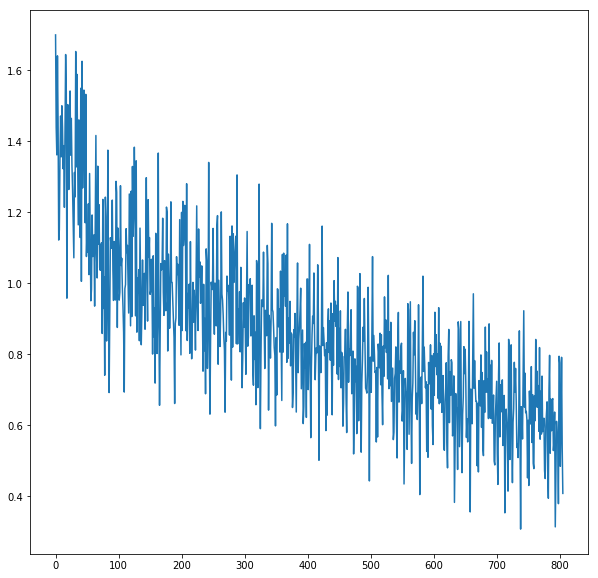

In [25]:
# plot the losses
plt.plot([l.data.cpu().numpy()[0] for l in losses])

In [26]:
# check one of the test images
test_ind = 100
input_img = torch.unsqueeze(variable(dg_dataset_val[test_ind], volatile=True), dim=0) 
mask = model(input_img)


mask_im = mask.squeeze().data.cpu().numpy()
mask_binary = mask_im.copy()

fig, ax = plt.subplots(1,2, figsize=(20,10))
thresh = 0
mask_binary[mask_im<=thresh] = 0
mask_binary[mask_im>thresh] = 1
ax[0].imshow(mask_binary)
# ax[0].colorbar()
gt_im = gt_dataset_val[test_ind].numpy().squeeze()
ax[1].imshow(mask_im)
# ax[1].colorbar()
plt.show()

source_im = dg_dataset_val[test_ind].numpy()
plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
plt.show()



RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518241081361/work/torch/lib/THC/generic/THCStorage.cu:58

In [27]:
# save current state
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

root = Path('runs/debug')
model_path = root / 'model_11.pt'
ep=epoch
step=i

save(ep)

In [ ]:
#load model
if model_path.exists():
    state = torch.load(str(model_path))
    epoch = state['epoch']
    step = state['step']
    model.load_state_dict(state['model'])
    print('Restored model, epoch {}, step {:,}'.format(epoch, step))